In [1]:
import warnings

import argparse
import os, sys, importlib
from glob import glob
import pickle

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import scipy

from utilities import reduced_parameter as red
from field.utils import profiling_rad

import utilities.reduced_parameter as red

from utilities.etc import categorizing_pickle, moving_average
from analyze_tools.monte_carlo import get_colliding_time
#from analyze_tools.utils import field_spectra, DipoleSpectra
import analyze_tools.utils as spectra_utils

import animation as an
from analyze_tools.IR_DACF import calc_FFT, calc_ACF, calc_derivative
import analyze_tools.utils as atu

import gc
import sklearn

plt.rcParams.update({
    #"text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

font = {'size'   : 12}
matplotlib.rc('font', **font)

#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20) 


Epsilon (erg) 1.6538969109051514e-14
Reduced epsilon (Ar-Ar, Ar-Xe, Xe-Xe): 1.0 ; 1.3825301204819278 ; 1.9116465863453815
CGS epsilon (Ar-Ar, Ar-Xe, Xe-Xe): 1.6538969109051514e-14 ; 2.286562295498387e-14 ; 3.161666383899004e-14
######################
Length multiple - Sigma (cm) 3.41e-08
Reduced sigma (Ar-Ar, Ar-Xe, Xe-Xe): 1.0 ; 1.095307917888563 ; 1.190615835777126
######################
Mass multiples (g) 6.633521465546083e-23
Reduced Mass (Ar, Xe): 1.0 ; 3.286597576849905
######################
Dipole unit multiple (statC . cm) 8.09814943451058e-19
Reduced dipole parameter:
mu0 =  0.08920009870622121
a =  7.8952761266316935
d0 =  1.1018059229945159
d7 =  0.030776244402154505
CGS dipole parameter:
mu0 =  7.223557288960733e-20
a = 2.32E+08
d0 =  3.757158197411299e-08
######################
Time 2.159594587679023e-12
Velocity multiple (cm/s) 15790.00067630667
Temperature  119.79126562255514
######################
c:  1899936.5874009002
Epsilon parameters matrix 
[[1.         1.3825301

In [3]:
#
# Define paths to pickle files
# Defining functions
#

linestyle_list = ["solid", "dashed", "dotted","dashdot"]
scatter_list = ["o", "^","v"]
colors_list = ['r','b','g']

ROOT = os.path.expanduser('~/OneDrive - Emory/Research Data/mm_polariton/pickle_jar/')
ROOT2 = 'pickle_jar/'# ROOT # 

# define lists of temperature
temperature_list = ['292.0', '200.0', '100.0']
c_list = ['Lxy1e1', "Lxy2e1"] #

seed_free_256 = [2928, 82, 1008] # seed for free field case, the order match temperature_list
seed_free_512 = [512292, 512200, 512100] # seed for free field case, the order match temperature_list
seed_cave_256z = [100810,100120] # seed for cavity field case, the order match c_list
seed_cave_512z = [512100110,512100120] # seed for cavity field case, the order match c_list
seed_cave_768z = [768100110,768100120] # seed for cavity field case, the order match c_list
seed_cave_256b = [8100110, 8100120]
seed_cave_512b = [8512110, 8512120]
seed_cave_768b = [8768110, 8768120]

# define patterns of paths that lead to pickle file
freefield_256_path = lambda t,s: ROOT2 + "free-{}_256_{}-zero_0_0".format(t,s)
freefield_512_path = lambda t,s: ROOT2 + "free-{}_512_{}-zero_0_0".format(t,s)
freefield_512b_path_100 = "free-100_512_100100-boltzmann_0_0"
cavityfield_256z_path = lambda t,s,c: ROOT2 + "cavity-{}_256_{}-zero_0_0-c_{}-microz".format(t,s,c)
cavityfield_512z_path = lambda t,s,c: ROOT2 + "cavity-{}_512_{}-zero_0_0-c_{}-microz".format(t,s,c)
cavityfield_768z_path = lambda t,s,c: ROOT2 + "cavity-{}_768_{}-zero_0_0-c_{}-microz".format(t,s,c)
cavityfield_256b_path = lambda t,s,c: ROOT2 + "cavity-{}_256_{}-boltzmann_0_0-c_{}-microz".format(t,s,c)
cavityfield_512b_path = lambda t,s,c: ROOT2 + "cavity-{}_512_{}-boltzmann_0_0-c_{}-microz".format(t,s,c)
cavityfield_768b_path = lambda t,s,c: ROOT2 + "cavity-{}_768_{}-boltzmann_0_0-c_{}-microz".format(t,s,c)

for i, temp in enumerate(temperature_list):
    atu.check_path(freefield_256_path(temp, seed_free_256[i]))
    
for i, temp in enumerate(temperature_list):
    atu.check_path(freefield_512_path(temp, seed_free_512[i]))
    
for i, c in enumerate(c_list):
    atu.check_path(cavityfield_256z_path('100.0', seed_cave_256z[i], c))

for i, c in enumerate(c_list):
    atu.check_path(cavityfield_512z_path('100.0', seed_cave_512z[i], c))

for i, c in enumerate(c_list):
    atu.check_path(cavityfield_768z_path('100.0', seed_cave_768z[i], c))

for i, c in enumerate(c_list):
    atu.check_path(cavityfield_256b_path('100.0', seed_cave_256b[i], c))

for i, c in enumerate(c_list):
    atu.check_path(cavityfield_512b_path('100.0', seed_cave_512b[i], c))

for i, c in enumerate(c_list):
    atu.check_path(cavityfield_768b_path('100.0', seed_cave_768b[i], c))
    

FREEFIELD_RESULT_256_DICT = { # result in free field path
    temp: freefield_256_path(temp,seed_free_256[i])
    for i, temp in enumerate(temperature_list)
}
FREEFIELD_RESULT_512_DICT = { # result in free field path
    temp: freefield_512_path(temp,seed_free_512[i])
    for i, temp in enumerate(temperature_list)
}
FREEFIELD_RESULT_512b_DICT_100 = { # result in free field path
    '100.0': freefield_512b_path_100
}
CAVITYFIELD_RESULT_256z_DICT = { # result in cavity field path
    c: cavityfield_256z_path('100.0',seed_cave_256z[i], c)
    for i, c in enumerate(c_list)
}
CAVITYFIELD_RESULT_512z_DICT = { # result in cavity field path
    c: cavityfield_512z_path('100.0',seed_cave_512z[i], c)
    for i, c in enumerate(c_list)
}
CAVITYFIELD_RESULT_768z_DICT = { # result in cavity field path
    c: cavityfield_768z_path('100.0',seed_cave_768z[i], c)
    for i, c in enumerate(c_list)
}
CAVITYFIELD_RESULT_256b_DICT = { # result in cavity field path
    c: cavityfield_256b_path('100.0',seed_cave_256b[i], c)
    for i, c in enumerate(c_list)
}
CAVITYFIELD_RESULT_512b_DICT = { # result in cavity field path
    c: cavityfield_512b_path('100.0',seed_cave_512b[i], c)
    for i, c in enumerate(c_list)
}
CAVITYFIELD_RESULT_768b_DICT = { # result in cavity field path
    c: cavityfield_768b_path('100.0',seed_cave_768b[i], c)
    for i, c in enumerate(c_list)
}

#
# DEFINING COLLISION TIME BELOW
# CURRENT DIPOLE THRESHOLD: CHECK BELOW
#

def getall_colliding_time(result_dict_path, limit = None, keys = None):
    directory_dict = categorizing_pickle(result_dict_path, '')
    
    all_colliding_time = np.array([])
    all_dipole_maxima = np.array([])

    n_pickle = 0
    if keys:
        directory_dict_keys = keys
    else:
        directory_dict_keys = sorted(list(directory_dict.keys()))

    print(directory_dict_keys)
    for i, j in enumerate(directory_dict_keys):
        path = directory_dict[j]
        if limit and n_pickle >= limit: 
            break

        try:
            with open(path, 'rb') as handle:
                result_dict = pickle.load(handle)
        except:
            print(path)
            continue
            
        atoms = result_dict['atoms']
        
        time, no_dipole_maxima = get_colliding_time(atoms, dipole_threshold = 0) #<=====HERE
    
        all_colliding_time = np.hstack([all_colliding_time, time])
        all_dipole_maxima = np.hstack([all_dipole_maxima, no_dipole_maxima])

        del result_dict
        n_pickle += 1
        
    return all_colliding_time, all_dipole_maxima

limit = {'256':40, '512':20, '768':15}


/Users/macbook/code/mm_polariton/src/analyze_tools/utils.py:14: UserWarning: Path pickle_jar/cavity-100.0_768_768100110-zero_0_0-c_Lxy1e1-microz does not exist!
  warnings.warn('Path {} does not exist!'.format(path))
/Users/macbook/code/mm_polariton/src/analyze_tools/utils.py:14: UserWarning: Path pickle_jar/cavity-100.0_768_768100120-zero_0_0-c_Lxy2e1-microz does not exist!
  warnings.warn('Path {} does not exist!'.format(path))
/Users/macbook/code/mm_polariton/src/analyze_tools/utils.py:14: UserWarning: Path pickle_jar/cavity-100.0_768_8768110-boltzmann_0_0-c_Lxy1e1-microz does not exist!
  warnings.warn('Path {} does not exist!'.format(path))
/Users/macbook/code/mm_polariton/src/analyze_tools/utils.py:14: UserWarning: Path pickle_jar/cavity-100.0_768_8768120-boltzmann_0_0-c_Lxy2e1-microz does not exist!
  warnings.warn('Path {} does not exist!'.format(path))


/Users/macbook/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/macbook/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Free-Space Collision-Induced Spectra of Ar-Xe Gas')

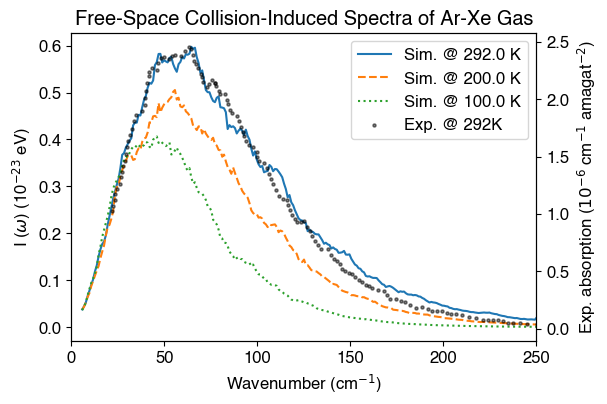

In [4]:
## from copy import deepcopy

fig,ax = plt.subplots(figsize = (6,4))
plt.rcParams.update({'font.size': 12})

# plotting the experimental dataset
tax = ax.twinx()
exp_data = pd.read_csv('data/plot-data.csv')
tax.scatter(
    exp_data.loc[:,'x'],
    exp_data.loc[:,' y'],
    s = 5, alpha = 0.5, c = 'black', 
    label = 'Exp. @ 292K'# if i == 0 else None
)
tax.set_ylabel(r'Exp. absorption ($10^{-6}$ cm$^{-1}$ amagat$^{-2}$)')
#tax.set_ylim(-0.00,2.5)

freefield_data = {}

for i,(temp, freefield_result_path) in enumerate(FREEFIELD_RESULT_512_DICT.items()):

    # loop over all pickle file in the directory to calculate the mean spectrum
    # copy from here
    
    directory_dict = categorizing_pickle(freefield_result_path, '')

    rad_profile = []
    for _, (j, path) in enumerate(directory_dict.items()):
        
        with open(path, 'rb') as handle:
            freefield_result_dict = pickle.load(handle)

        omega_profile, rad_profile1 = spectra_utils.field_spectra(
            freefield_result_dict, 
            convert_function = {
                'energy': red.convert_energy, 
                'wavenumber':red.convert_wavenumber},
            mode = 'std'
        ) 
        rad_profile.append(rad_profile1)

        del freefield_result_dict

    rad_profile = np.mean(rad_profile, axis = 0)
    
    rad_profile *= 1e23 ##############################################################
    
    o, f = moving_average(omega_profile, rad_profile, w = 10)
    f = f[o > 5]
    o = o[o > 5]
    ax.plot(o, f, label = "Sim. @ {} K".format(temp), linestyle = linestyle_list[i])

    if temp == '100.0':
        rad_profile100 = f
        omega_profile100 = o
    elif temp == '292.0':
        rad_profile292 = f
        omega_profile292 = o
    freefield_data.update({temp:(o,f)})

ax.scatter([], [], s = 5, alpha = 0.5, c = 'black', label = 'Exp. @ 292K')     
ax.legend()
    #loc='lower center', bbox_to_anchor=(0.5, 0.88), ncol=3)

ax.set_xlim(0,250)
#ax.set_ylim(0.0, 0.61)
ax.set_ylabel(r"I ($\omega$) (10$^{-23}$ eV)")
ax.set_xlabel(r"Wavenumber (cm$^{-1}$)")

ax.set_title("Free-Space Collision-Induced Spectra of Ar-Xe Gas")

#fig.savefig("MSfig/figure/free_spectrum.jpeg",dpi = 600, bbox_inches = 'tight')

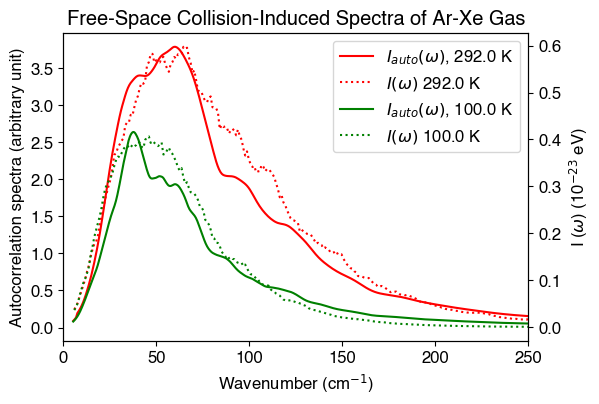

In [7]:
fig,ax = plt.subplots(figsize = (6,4))
plt.rcParams.update({'font.size': 12})

tax = ax.twinx()

spec_calculator = spectra_utils.DipoleSpectra(
    dtps = 1e-2, time_frame = None,
    convert_function = {
        'energy': red.convert_energy, 
        'wavenumber':red.convert_wavenumber, 
        'time':red.convert_time
    })

for i,(temp, freefield_result_path) in enumerate(FREEFIELD_RESULT_512_DICT.items()):

    # loop over all pickle file in the directory to calculate the mean spectrum
    # copy from here
    if temp == '200.0': continue
    directory_dict = categorizing_pickle(freefield_result_path, '')

    rad_profile = []
    for _, (j, path) in enumerate(directory_dict.items()):
        
        with open(path, 'rb') as handle:
            freefield_result_dict = pickle.load(handle)

        spec_calculator.add_result_dict(freefield_result_dict)

        del freefield_result_dict

    omega_profile, rad_profile = spec_calculator()
    rad_profile = np.mean(rad_profile, axis = 0)
    o, f = moving_average(omega_profile, rad_profile, w = 20)
    f = f[o > 5]
    o = o[o > 5]
    f *= 1e5
    ax.plot(o, f, label = r"$I_{auto}(\omega)$,"+" {} K".format(temp),  color = colors_list[i])

    o,f = freefield_data[temp]
    tax.plot(
        o, f, linestyle = linestyle_list[2], 
        color = colors_list[i]
    )
    ax.plot([], [], label = r"$I(\omega)$"+" {} K".format(temp), 
        color = colors_list[i], linestyle = linestyle_list[2])

ax.legend()
    #loc='lower center', bbox_to_anchor=(0.5, 0.88), ncol=3)

ax.set_xlim(0,250)
#ax.set_ylim(0.0, 0.61)
ax.set_ylabel("Autocorrelation spectra (arbitrary unit)")
tax.set_ylabel(r"I ($\omega$) (10$^{-23}$ eV)")
ax.set_xlabel(r"Wavenumber (cm$^{-1}$)")

ax.set_title("Free-Space Collision-Induced Spectra of Ar-Xe Gas")

fig.savefig('SIfig/figure/autocor_freefield0K.jpeg',dpi = 600, bbox_inches = 'tight')

/Users/macbook/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/macbook/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/macbook/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/macbook/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


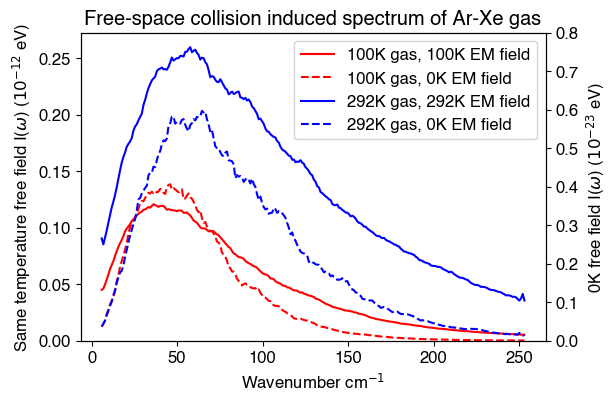

In [5]:
fig,ax = plt.subplots(figsize = (6,4))
#fig.subplots_adjust(hspace = 0.35)

directory_dict_list = [
    categorizing_pickle('pickle_jar/free-100.0_512_100100-boltzmann_0_0', ''),
    categorizing_pickle('pickle_jar/free-292.0_512_29200-boltzmann_0_0', '')
]

tax = ax.twinx()
exp_data = pd.read_csv('data/plot-data.csv')
o,f = freefield_data['100.0']
tax.plot(o, f,linestyle = 'dashed', c = 'r', label = '0K EM field')
tax.set_ylabel(r'0K free field I($\omega$) ($10^{-23}$ eV)')

exp_data = pd.read_csv('data/plot-data.csv')
o,f = freefield_data['292.0']
tax.plot(o,f,linestyle = 'dashed', c = 'b', label = '0K EM field')
tax.set_ylabel(r'0K free field I($\omega$) ($10^{-23}$ eV)')

temp_list = [100, 292]
colors_list = ['r','b']
for i, directory_dict in enumerate(directory_dict_list):
    rad_profile = []
    rad_profile1 = []
    no_pickle = 0

    directory_dict_keys = sorted(list(directory_dict.keys()))
    
    for _, j in enumerate(directory_dict_keys):
        path = directory_dict[j]
        
        with open(path, 'rb') as handle:
            freefield_result_dict = pickle.load(handle)
    
        #print(j, np.sum(freefield_result_dict['field'].history['energy'][-1]))
    
        omega_profile, r = spectra_utils.field_spectra(
            freefield_result_dict, 
            convert_function = {
                'energy': red.convert_energy, 
                'wavenumber':red.convert_wavenumber},
            mode = 'std'
        ) 
        rad_profile.append(r)
        
        del freefield_result_dict
        no_pickle += 1
        if no_pickle >= 100:
            break
        
    rad_profile = np.mean(rad_profile, axis = 0)
    rad_profile *= 1e12
    o, f = moving_average(omega_profile, rad_profile, w = 12)
    f = f[o > 5]
    o = o[o > 5]
    if temp_list[i] == 100:
        rad_profile100b = f
        omega_profile100b = o
    
    ax.set_ylabel(
        'Same temperature free field'.format(temp_list[i]) + r' I($\omega$) ($10^{-12}$ eV)')
    ax.plot(
        o, f, label = '{}K gas, {}K EM field'.format(temp_list[i],temp_list[i]), 
        c = colors_list[i])
    ax.plot(
        [], [], label = '{}K gas, 0K EM field'.format(temp_list[i]), 
        linestyle = 'dashed', c = colors_list[i], )
    ax.legend()
    ax.set_title(
        'Free-space collision induced spectrum of Ar-Xe gas')
    ax.set_xlabel(r'Wavenumber cm$^{-1}$')


tax.set_ylim(0.00, 0.80)
ax.set_ylim(bottom = 0)
    
fig.savefig('SIfig/figure/free_space_100.jpeg', dpi=600, bbox_inches = 'tight')

/Users/macbook/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/macbook/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/macbook/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/macbook/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


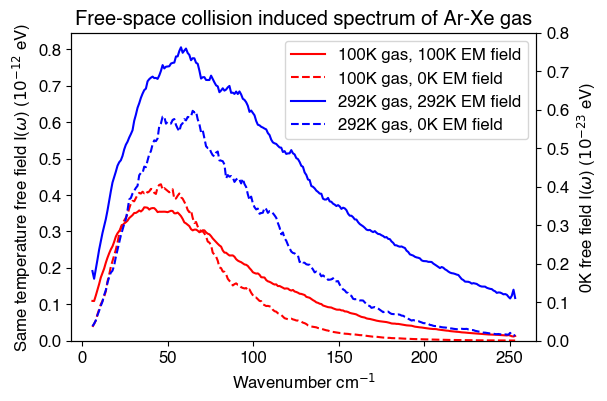

In [7]:
fig,ax = plt.subplots(figsize = (6,4))
#fig.subplots_adjust(hspace = 0.35)

rad_profile_list = []

directory_dict_list = [
    categorizing_pickle('pickle_jar/free-100.0_512_100100-boltzmann_0_0', ''),
    categorizing_pickle('pickle_jar/free-292.0_512_29200-boltzmann_0_0', '')
]

tax = ax.twinx()
exp_data = pd.read_csv('data/plot-data.csv')
o,f = freefield_data['100.0']
tax.plot(o, f,linestyle = 'dashed', c = 'r', label = '0K EM field')
tax.set_ylabel(r'0K free field I($\omega$) ($10^{-23}$ eV)')

exp_data = pd.read_csv('data/plot-data.csv')
o,f = freefield_data['292.0']
tax.plot(o,f,linestyle = 'dashed', c = 'b', label = '0K EM field')
tax.set_ylabel(r'0K free field I($\omega$) ($10^{-23}$ eV)')

temp_list = [100, 292]
colors_list = ['r','b']
for i, directory_dict in enumerate(directory_dict_list):
    rad_profile = []
    rad_profile1 = []
    no_pickle = 0

    directory_dict_keys = sorted(list(directory_dict.keys()))
    
    for _, j in enumerate(directory_dict_keys):
        path = directory_dict[j]
        
        with open(path, 'rb') as handle:
            freefield_result_dict = pickle.load(handle)
    
        #print(j, np.sum(freefield_result_dict['field'].history['energy'][-1]))
    
        omega_profile, r = spectra_utils.field_spectra(
            freefield_result_dict, 
            convert_function = {
                'energy': red.convert_energy, 
                'wavenumber':red.convert_wavenumber},
            mode = 'abs'
        ) 
        rad_profile.append(r)
        
        #del freefield_result_dict
        no_pickle += 1
        if no_pickle >= 100:
            break
        
    rad_profile = np.mean(rad_profile, axis = 0)
    rad_profile *= 1e12

    rad_profile_list.append(rad_profile)
    
    o, f = moving_average(omega_profile, rad_profile, w = 12)
    f = f[o > 5]
    o = o[o > 5]
    if temp_list[i] == 100:
        rad_profile100b = f
        omega_profile100b = o
    
    ax.set_ylabel(
        'Same temperature free field'.format(temp_list[i]) + r' I($\omega$) ($10^{-12}$ eV)')
    ax.plot(
        o, f, label = '{}K gas, {}K EM field'.format(temp_list[i],temp_list[i]), 
        c = colors_list[i])
    ax.plot(
        [], [], label = '{}K gas, 0K EM field'.format(temp_list[i]), 
        linestyle = 'dashed', c = colors_list[i], )
    ax.legend()
    ax.set_title(
        'Free-space collision induced spectrum of Ar-Xe gas')
    ax.set_xlabel(r'Wavenumber cm$^{-1}$')


tax.set_ylim(0.00, 0.80)
ax.set_ylim(bottom = 0)
    
fig.savefig('SIfig/figure/free_space_100.jpeg', dpi=600, bbox_inches = 'tight')

In [13]:
np.mean(rad_profile) * 1e-12

(0.05032870552022546+0j)

In [39]:
red.a * red.mu0

0.704259409808419

In [19]:
freefield_result_dict['field'].history['C'][0]

array([[ 1.84260449e+06+8.36632590e+06j,  5.05262820e+06+2.29414041e+07j],
       [ 4.80430643e+06+3.54473094e+06j,  5.10657005e+06+3.76774819e+06j],
       [ 3.99137172e+06-6.89596203e+06j,  2.37540723e+06-4.10403220e+06j],
       [-2.25496878e+05+1.36581587e+06j, -4.02129319e+05+2.43566390e+06j],
       [ 6.35201587e+05-9.59199056e+05j,  1.98901768e+06-3.00355654e+06j],
       [-4.34812902e+05+1.36979484e+06j, -9.77115973e+05+3.07821689e+06j],
       [-1.12363431e+06+1.31773683e+06j, -1.47586164e+06+1.73080976e+06j],
       [ 1.02281339e+03+1.85166284e+06j,  4.91162716e+02+8.89182485e+05j],
       [-2.68133127e+06+1.49407197e+06j, -2.11174019e+06+1.17668856e+06j],
       [-1.63499659e+05-4.69301026e+05j, -4.19266330e+05-1.20344054e+06j],
       [-9.07530293e+05+1.08179308e+06j, -1.39178855e+06+1.65903798e+06j],
       [-3.61458587e+05+8.65175092e+05j, -4.50564114e+05+1.07845508e+06j],
       [-1.12391359e+06-5.55323629e+05j, -5.33135790e+05-2.63421410e+05j],
       [ 8.45271164e+05-1

In [74]:
mu_dot = np.array(
    freefield_result_dict['atoms'].observable['dipole_velocity'])

mu_dot = np.sqrt(np.einsum('ijk,ijk->ij',mu_dot,mu_dot))
mu_dot = np.mean(mu_dot, axis = 1)
mu_dot

array([9.00468263e-08, 9.59944455e-08, 1.02421438e-07, 1.09373809e-07,
       1.16902719e-07, 1.25065147e-07, 1.33924649e-07, 1.43552235e-07,
       1.54027369e-07, 1.65439131e-07, 1.77887549e-07, 1.91485149e-07,
       2.06358744e-07, 2.22651511e-07, 2.40525411e-07, 2.60163987e-07,
       2.81775639e-07, 3.05597403e-07, 3.31899354e-07, 3.60989664e-07,
       3.93220405e-07, 4.28994103e-07, 4.68770981e-07, 5.13076701e-07,
       5.62510101e-07, 6.17749978e-07, 6.79559078e-07, 7.48782017e-07,
       8.26331352e-07, 9.13151823e-07, 1.01014569e-06, 1.11803033e-06,
       1.23707956e-06, 1.36666829e-06, 1.50449057e-06, 1.64530537e-06,
       1.80606207e-06, 2.02408922e-06, 2.32402832e-06, 2.74621047e-06,
       3.40694248e-06, 4.46374001e-06, 6.17038376e-06, 9.06897332e-06,
       1.38713589e-05, 2.19627491e-05, 3.53666454e-05, 5.75145840e-05,
       9.38439098e-05, 1.53165174e-04, 2.49270363e-04, 4.03200889e-04,
       6.47673459e-04, 1.03177777e-03, 1.62585471e-03, 2.52165500e-03,
      

In [72]:
mu_dot.shape

(960,)

In [32]:
foo1 = red.convert_energy(
    np.mean(rad_profile_list[0]),
    'ev'
) * 1e-10

In [33]:
foo1 = red.convert_energy(
    np.mean(rad_profile_list[1]),
    'ev'
) * 1e-10

In [35]:
foo1 / foo0

(2.91964327341337+0j)

In [14]:
directory_dict = categorizing_pickle('pickle_jar/free-292.0_512_29200-boltzmann_0_0', '')
#for i, (temp, cavityfield_result_path) in enumerate(CAVITYFIELD_RESULT_512b_DICT.items()):
#print(temp)

#directory_dict = categorizing_pickle(cavityfield_result_path, '')
for i_, (j, path) in enumerate(directory_dict.items()):
    try:
        with open(path, 'rb') as handle:
            result_dict = pickle.load(handle)
    except:
        print(path)
        continue

    field = result_dict['field']
    
    print(j, np.sum(field.history['energy'][-1]))

49 (1216.4328173874678+0j)
75 (1266.2578597244787+0j)
61 (1222.0669626311665+0j)
60 (1200.1576303338265+0j)
74 (1258.013825740797+0j)
48 (1333.610958908363+0j)
62 (1296.4941643641137+0j)
76 (1317.967187629884+0j)
89 (1250.0775539066892+0j)
88 (1224.9639038804805+0j)
77 (1281.1691200322603+0j)
63 (1271.4501734642108+0j)
67 (1238.5027114916147+0j)
73 (1254.302561511761+0j)
72 (1251.7106549387495+0j)
66 (1210.500434429176+0j)
70 (1250.9762237222917+0j)
64 (1248.9681725455853+0j)
58 (1333.0493814489223+0j)
59 (1274.868976800978+0j)
65 (1251.7621590190568+0j)
71 (1285.3401013975367+0j)
16 (1337.4305587220142+0j)
17 (1301.5705109206604+0j)
29 (1189.8426416904742+0j)
15 (1282.3277695794955+0j)
14 (1177.8002148282758+0j)
28 (1264.078887644272+0j)
10 (1210.726559428058+0j)
38 (1237.9880892496851+0j)
39 (1301.0939158653846+0j)
11 (1209.9102418980901+0j)
13 (1291.281942933202+0j)
9 (1361.348166833891+0j)
8 (1204.374613436872+0j)
12 (1286.9640790299368+0j)
5 (1214.141792721165+0j)
37 (1290.7525229

/home/ribeirogroup/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ribeirogroup/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


512 100.0 (18.226459043084112+0j) 1.7233597099372244
256 100.0 (12.883979443212432+0j) 1.6283471390995248


24866

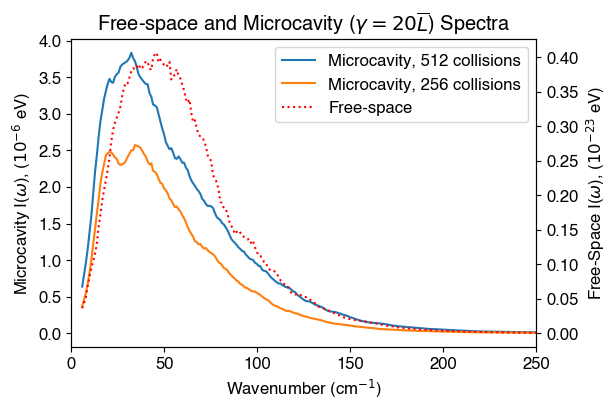

In [7]:
"""
################################################################################
################## STANDARD DEVIATION OF THE FIELD POWER SPECTRUM ##############
################################################################################
########################## 100K ATOM GAS - 0K CAVITY ###########################
################################################################################
"""

foo = {
    #'768':CAVITYFIELD_RESULT_768z_DICT,
    '512':CAVITYFIELD_RESULT_512z_DICT, 
    '256':CAVITYFIELD_RESULT_256z_DICT, 
}
limit = {'256':80, '512':40, '768':15}
colors = ['r', 'b']

fig,ax = plt.subplots(1, figsize = (6,4))

cavity0K_data = {}

for f_, (no_collision, result_dict) in enumerate(foo.items()):
    cavityfield_result_path = result_dict['Lxy2e1']
        
    directory_dict = categorizing_pickle(cavityfield_result_path, '')

    rad_profile = []
    rad_profile_ = [] # for calculating the final temperature
    n_pickle = 0
    for i_, (j, path) in enumerate(directory_dict.items()):
        try:
            with open(path, 'rb') as handle:
                result_dict = pickle.load(handle)
        except:
            print(path)
            continue

        # for calculating spectra
        omega_profile, rad_profile1 = spectra_utils.field_spectra(
            result_dict, 
            convert_function = {
                'energy': red.convert_energy, 
                'wavenumber':red.convert_wavenumber},
            mode = 'std'
        ) 
        rad_profile.append(rad_profile1)

        #for calculating the field final temperature
        omega_profile, rad_profile2 = spectra_utils.field_spectra(
            result_dict, 
            convert_function = {
                'wavenumber':red.convert_wavenumber},
            mode = 'final'
        ) 
        rad_profile_.append(rad_profile2)

        n_pickle += 1
        if n_pickle > limit[no_collision]: break

    rad_profile = np.mean(rad_profile, axis = 0)
    rad_profile *= 1e3
    o, f = moving_average(omega_profile, rad_profile, w = 10)
    f = f[o > 5]
    o = o[o > 5]
    ax.plot(o, f, label = 'Microcavity, {} collisions'.format(no_collision))
    # to here for rad profile - end of copy
    cavity0K_data.update({no_collision: (o,f)})

    ####
    if f_ == 0:
    ### tabe here ###
        ax.set_xlim(0, 250)
        
        tax = ax.twinx()
        o,f = freefield_data['100.0']
        tax.plot(o,f, linestyle = linestyle_list[2], c = colors[f_])
        tax.set_xlim(0, 250)
        #tax.set_ylim(0, 0.41)
    
        ax.set_ylabel(r"Microcavity I($\omega$), ($10^{-6}$ eV)")
        tax.set_ylabel(r"Free-Space I($\omega$), ($10^{-23}$ eV)")

    # print final temperature of the field
    temp_profile = np.mean(rad_profile_, axis = 1) * red.epsilon / (red.boltzmann * 2)
    print(no_collision, temp,  np.mean(temp_profile), np.std(temp_profile))

ax.plot(
    [], [], label = "Free-space" , 
    linestyle = linestyle_list[2],color=colors[0]
)

#ax.set_ylim(0, 4.0)

ax.set_xlabel(r'Wavenumber (cm$^{-1}$)')

ax.legend()

ax.set_title(r"Free-space and Microcavity ($\gamma = 20\overline{L}$) Spectra")

fig.savefig("SIfig/figure/cavity_spectrum.jpeg",dpi = 600,bbox_inches = 'tight')

gc.collect()

/home/ribeirogroup/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ribeirogroup/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


2888

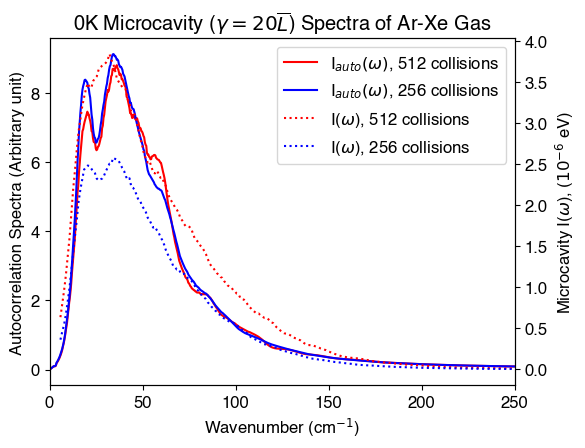

In [13]:
"""
################################################################################
### DIPOLE CURRENT - DIPOLE CURRENT AUTOCORRELATION FOR CALCULATING SPECTRUM ###
################################################################################
########################## 100K ATOM GAS - 0K CAVITY ###########################
################################################################################
"""

foo = {
    #'768':CAVITYFIELD_RESULT_768z_DICT,
    '512':CAVITYFIELD_RESULT_512z_DICT, 
    '256':CAVITYFIELD_RESULT_256z_DICT, 
}
limit = {'256':80, '512':40, '768':15}
colors = ['r', 'b']

fig,ax = plt.subplots(1, figsize = (6,4.5))
tax = ax.twinx()

spec_calculator = spectra_utils.DipoleSpectra(
    dtps = 1e-2, time_frame = (0,40),
    convert_function = {
        'energy': red.convert_energy, 
        'wavenumber':red.convert_wavenumber, 
        'time':red.convert_time
    })

for id, (no_collision, result_dict) in enumerate(foo.items()):
    cavityfield_result_path = result_dict['Lxy2e1']
        
    directory_dict = categorizing_pickle(cavityfield_result_path, '')

    rad_profile = []
    rad_profile_ = [] # for calculating the final temperature
    n_pickle = 0
    for i_, (j, path) in enumerate(directory_dict.items()):
        try:
            with open(path, 'rb') as handle:
                result_dict = pickle.load(handle)
        except:
            print(path)
            continue

        spec_calculator.add_result_dict(result_dict)
        
        n_pickle += 1
        if n_pickle > limit[no_collision]: break

    omega_profile, rad_profile = spec_calculator()
    rad_profile = np.mean(rad_profile, axis = 0)
    
    o, f = moving_average(omega_profile, rad_profile, w = 20)
    f *= 1e6
    ax.plot(
        o, f, label = r'I$_{auto}(\omega)$' + ', {} collisions'.format(no_collision),
        color=colors[id])
    # to here for rad profile - end of copy

    ####
    
    ax.set_xlim(0, 250)
    
    o_, f_ = cavity0K_data[no_collision]
    tax.plot(o_, f_, linestyle = 'dotted',color=colors[id])
    tax.set_xlim(0, 250)
    #tax.set_ylim(0, 0.41)

    ax.set_ylabel(r"Autocorrelation Spectra (Arbitrary unit)")
    tax.set_ylabel(r"Microcavity I($\omega$), ($10^{-6}$ eV)")
        
ax.plot(
    [], [], label = r"I($\omega$), 512 collisions" , 
    linestyle = "dotted",color=colors[0]
)
ax.plot(
    [], [], label = r"I($\omega$), 256 collisions" , 
    linestyle = "dotted",color=colors[1]
)

#ax.set_ylim(0, 4.0)

ax.set_xlabel(r'Wavenumber (cm$^{-1}$)')

ax.legend()

ax.set_title(r"0K Microcavity ($\gamma = 20\overline{L}$) Spectra of Ar-Xe Gas")

fig.savefig("SIfig/figure/autocor_cavity0K.jpeg",dpi = 600,bbox_inches = 'tight')

gc.collect()

/home/ribeirogroup/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ribeirogroup/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


512 Lxy1e1 (103.84975510257757+0j) 4.942530414592313
512 Lxy2e1 (105.81315208747112+0j) 3.90859896433758


10428

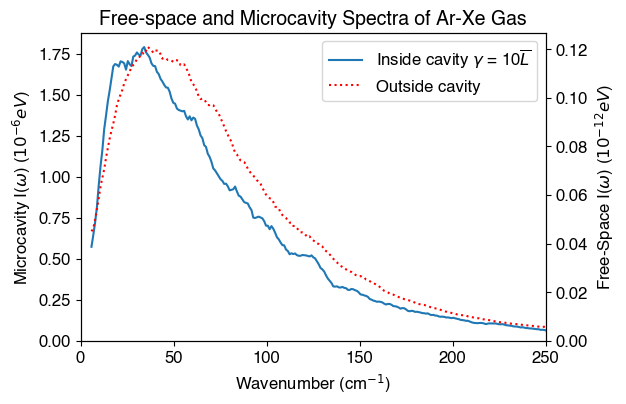

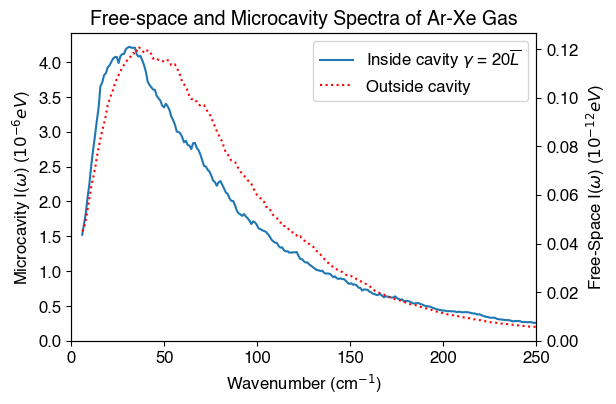

In [9]:
################################################################################
################## STANDARD DEVIATION OF THE FIELD POWER SPECTRUM ##############
######################## 100K ATOM GAS - 100K CAVITY ###########################
################################################################################

foo = {
    #'768':CAVITYFIELD_RESULT_768b_DICT,
    '512':CAVITYFIELD_RESULT_512b_DICT, 
    #'256':CAVITYFIELD_RESULT_256b_DICT, 
}
limit = {'256':40, '512':40, '768':15}
colors = ['r', 'b', 'g']
ct_label = {'Lxy1e1': "10", "Lxy2e1":"20"}

fig1,ax1 = plt.subplots(figsize = (6,4))
fig2,ax2 = plt.subplots(figsize = (6,4))
fig = [fig1, fig2]
ax = [ax1, ax2]
max_r = {}

cavity100K_data = {}

for f_, (no_collision, result_dict) in enumerate(foo.items()):
    for i, (temp, cavityfield_result_path) in enumerate(result_dict.items()):
        
        directory_dict = categorizing_pickle(cavityfield_result_path, '')
    
        rad_profile = []
        rad_profile_ = [] # for calculating the final temperature
        n_pickle = 0
        directory_dict_key = sorted(list(directory_dict.keys()))
        
        for i_, j in enumerate(directory_dict_key):
            path = directory_dict[j]
            try:
                with open(path, 'rb') as handle:
                    result_dict = pickle.load(handle)
            except:
                print(path)
                continue
    
            omega_profile, rad_profile1 = spectra_utils.field_spectra(
                result_dict, 
                convert_function = {
                    'energy': red.convert_energy, 
                    'wavenumber':red.convert_wavenumber},
                mode = 'std'
            ) 
            rad_profile.append(rad_profile1)

            #for calculating the field final temperature
            omega_profile, rad_profile2 = spectra_utils.field_spectra(
                result_dict, 
                convert_function = {
                    'wavenumber':red.convert_wavenumber},
                mode = 'final'
            ) 
            rad_profile_.append(rad_profile2)
            
            #del result_dict
            
            n_pickle += 1
            if n_pickle >= limit[no_collision]: break
    
        rad_profile = np.mean(rad_profile, axis = 0)
        rad_profile *= 1e3
        o, f = moving_average(omega_profile, rad_profile, w = 10)
        f = f[o > 5]
        o = o[o > 5]
        
        cavity100K_data.update({temp:(o,f)})
        
        ax[i].plot(o, f, label = r'Inside cavity $\gamma$ = {}'.format(ct_label[temp]) + r'$\overline{L}$' )
        # to here for rad profile - end of copy
    
        ####
        if f_ == 0:
            max_r.update({i:np.max(rad_profile)})
            
            #### tab here ###
            tax = ax[i].twinx()
            tax.plot(
                omega_profile100b, rad_profile100b * (np.max(rad_profile)/ max_r[i]), 
                linestyle = linestyle_list[2], c = colors[f_]
            )
            tax.set_xlim(0, 250)
            tax.set_ylim(bottom = 0)
        
            ax[i].set_ylabel(r"Microcavity I($\omega$) ($10^{-6} eV$)")
            tax.set_ylabel(r"Free-Space I($\omega$) ($10^{-12} eV$)")
            
        ax[i].set_xlim(0, 250)
        ax[i].set_ylim(bottom = 0)
        
        # print final temperature of the field
        temp_profile = np.mean(rad_profile_, axis = 1) * red.epsilon / (red.boltzmann * 2)
        print(no_collision, temp,  np.mean(temp_profile), np.std(temp_profile))
        

        ax[i].plot(
            [], [], label = "Outside cavity" , 
            linestyle = linestyle_list[2],color=colors[0]
        )
        ax[i].set_title(r"Free-space and Microcavity Spectra of Ar-Xe Gas", fontsize = 14)
"""
ax[0].plot(
    [], [], label = "Outside cavity, rescale" , 
    linestyle = linestyle_list[2],color=colors[1]
)
"""

#ax[0].set_ylim(0, 1.9)
#ax[1].set_ylim(0, 4.5)
ax[0].set_xlabel(r'Wavenumber (cm$^{-1}$)')
ax[1].set_xlabel(r'Wavenumber (cm$^{-1}$)')

#ax[0].annotate(r'$\gamma = 10\bar{L}$',xy = (0.7,0.6), xycoords = 'axes fraction', fontsize = 'x-large')
#ax[1].annotate(r'$\gamma = 20\bar{L}$',xy = (0.7,0.6), xycoords = 'axes fraction', fontsize = 'x-large')

#ax[0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=2)
ax[0].legend()
ax[1].legend()

fig[1].savefig("MSfig/figure/boltzmann_cavity_spectrum.jpeg",dpi = 600,bbox_inches = 'tight')
fig[0].savefig("SIfig/figure/boltzmann_cavity_spectrum_10L.jpeg",dpi = 600,bbox_inches = 'tight')
fig[1].savefig("SIfig/figure/boltzmann_cavity_spectrum_20L.jpeg",dpi = 600,bbox_inches = 'tight')

gc.collect()

/home/ribeirogroup/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ribeirogroup/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


18918

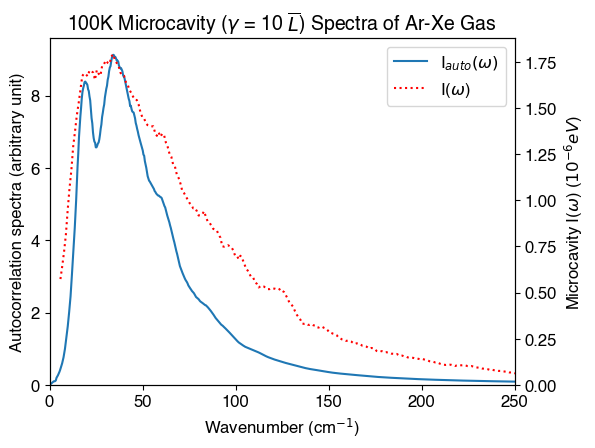

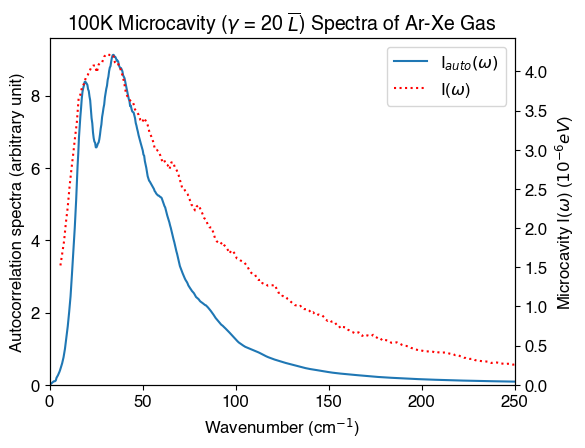

In [12]:
################################################################################
### DIPOLE CURRENT - DIPOLE CURRENT AUTOCORRELATION FOR CALCULATING SPECTRUM ###
######################## 100K ATOM GAS - 100K CAVITY ###########################
################################################################################

foo = {
    #'768':CAVITYFIELD_RESULT_768b_DICT,
    '512':CAVITYFIELD_RESULT_512b_DICT, 
    #'256':CAVITYFIELD_RESULT_256b_DICT, 
}
limit = {'256':40, '512':40, '768':15}
colors = ['r', 'b', 'g']
ct_label = {'Lxy1e1': "10", "Lxy2e1":"20"}

fig1,ax1 = plt.subplots(figsize = (6,4.5))
fig2,ax2 = plt.subplots(figsize = (6,4.5))

tax1 = ax1.twinx()
tax2 = ax2.twinx()

fig = [fig1, fig2]
ax = [ax1, ax2]
tax = [tax1, tax2]
max_r = {}

spec_calculator2 = spectra_utils.DipoleSpectra(
    dtps = 1e-2, time_frame = (0,25),
    convert_function = {
        'energy': red.convert_energy, 
        'wavenumber':red.convert_wavenumber, 
        'time':red.convert_time
    })


for f_, (no_collision, result_dict) in enumerate(foo.items()):
    for i, (temp, cavityfield_result_path) in enumerate(result_dict.items()):
        
        directory_dict = categorizing_pickle(cavityfield_result_path, '')
    
        rad_profile = []
        rad_profile_ = [] # for calculating the final temperature
        n_pickle = 0
        
        directory_dict_key = sorted(list(directory_dict.keys()))
        
        for i_, j in enumerate(directory_dict_key):
            path = directory_dict[j]
            try:
                with open(path, 'rb') as handle:
                    result_dict = pickle.load(handle)
            except:
                print(path)
                continue
    
            spec_calculator2.add_result_dict(result_dict)
            
            #del result_dict
            
            n_pickle += 1
            if n_pickle >= limit[no_collision]: break
    
        omega_profile, rad_profile = spec_calculator()
        rad_profile = np.mean(rad_profile, axis = 0)
        
        o, f = moving_average(omega_profile, rad_profile, w = 20)
        f *= 1e6
        ax[i].plot(o, f, label = r'I$_{auto}(\omega)$' )
        # to here for rad profile - end of copy
    
            
        #### tab here ###
        o_, f_ = cavity100K_data[temp]
        tax[i].plot(o_,f_, linestyle = linestyle_list[2], c = colors[0])
        tax[i].set_xlim(0, 250)
        tax[i].set_ylim(bottom = 0)
    
        ax[i].set_ylabel(r"Autocorrelation spectra (arbitrary unit)")
        tax[i].set_ylabel(r"Microcavity I($\omega$) ($10^{-6} eV$)")
        
        ax[i].set_xlim(0, 250)
        ax[i].set_ylim(bottom = 0)
        
        ax[i].plot(
            [], [], label = r"I($\omega$)" , 
            linestyle = linestyle_list[2],color=colors[0]
        )
        
        ax[i].set_title(
            r"100K Microcavity ($\gamma$ = {}".format(ct_label[temp]) + r" $\overline{L}$) Spectra of Ar-Xe Gas", 
            fontsize = 14)
"""
ax[0].plot(
    [], [], label = "Outside cavity, rescale" , 
    linestyle = linestyle_list[2],color=colors[1]
)
"""

#ax[0].set_ylim(0, 1.9)
#ax[1].set_ylim(0, 4.5)
ax[0].set_xlabel(r'Wavenumber (cm$^{-1}$)')
ax[1].set_xlabel(r'Wavenumber (cm$^{-1}$)')

#ax[0].annotate(r'$\gamma = 10\bar{L}$',xy = (0.7,0.6), xycoords = 'axes fraction', fontsize = 'x-large')
#ax[1].annotate(r'$\gamma = 20\bar{L}$',xy = (0.7,0.6), xycoords = 'axes fraction', fontsize = 'x-large')

#ax[0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=2)
ax[0].legend()
ax[1].legend()

fig[1].savefig("SIfig/figure/autocor_cavity100K_20L.jpeg",dpi = 600,bbox_inches = 'tight')

gc.collect()

In [ ]:
directory_dict = categorizing_pickle(CAVITYFIELD_RESULT_512b_DICT['Lxy2e1'], '')
path = directory_dict[4]
with open(path, 'rb') as handle:
    result_dict = pickle.load(handle)

In [ ]:
timeline = np.array(result_dict['atoms'].observable['t'])
timeline -= timeline[0]

dipole_vs_time = []
atoms = result_dict['atoms']
for i in range(len(result_dict['atoms'].observable['t'])):
    r = atoms.trajectory["r"][i]

    # Note that simulation run from simulation_monte.py arrange argons' and xenon' indices separately
    # e.g. R = [r_{Ar,1}, r_{Ar,2}, ... , r_{Ar,N}, r_{Xe,1}, r_{Xe,2}, ... , r_{Xe,N}]
    r_ar = r[0:512]
    r_xe = r[512:]
    dvec = (r_ar - r_xe)

    d = np.sqrt(np.einsum("ni,ni->n",dvec,dvec))

    #dipole = red.mu0 * np.exp(-red.a * (d - red.d0)) - red.d7/d**7
    dipole = 4 * red.epsilon_ * ( (red.sigma_/d)**12 - (red.sigma_/d)**6 )

    dipole_vs_time.append(dipole)

dipole_vs_time = np.array(dipole_vs_time)

In [ ]:
from scipy.signal import argrelmax

complexes = []
for i in range(512):
    d = dipole_vs_time[:,i]
    d = np.where(d < 1e-4, 0, d)
    maxima = argrelmax(d)[0]
    if len(maxima) > 1:
        true_maxima = 1
        for j in range(1,len(maxima)):
            if min(d[maxima[j-1]:maxima[j]]) < 0.5 * max(d[maxima[j-1]:maxima[j]]):
                true_maxima += 1
        if true_maxima > 1:
            complexes.append(i)

complexes = np.array(complexes)
        

In [ ]:
all_colliding_time = []

for i in range(512):
    try:
        ti = timeline[dipole_vs_time[:,i]>0][0]
        tf = timeline[dipole_vs_time[:,i]>0][-1]
        all_colliding_time.append(
            red.convert_time(tf - ti))
    except IndexError:
        all_colliding_time.append(0)
        

all_colliding_time = np.array(all_colliding_time)

In [ ]:
print(np.min(all_colliding_time[complexes]))
np.argmin(all_colliding_time[complexes])

In [ ]:
fig,ax = plt.subplots()
# thres = 0.5, path = 4
i = complexes[44]
ax.plot(timeline[:1000],dipole_vs_time[:1000,i])

In [ ]:
##################################
# HISTOGRAM OF COLLISION TIME    #
# Initially zero amplitude field #
##################################

foo = {
    '256':CAVITYFIELD_RESULT_256z_DICT, 
    '512':CAVITYFIELD_RESULT_512z_DICT}

letters = ['a', 'b', 'c']

ct_dict = {}
dm_dict = {}

limit = {'256':80, '512':40, '768':15}

for j,(no_collision, result_dict) in enumerate(foo.items()):
    food = {}
    for i, coup_str in enumerate(['Lxy2e1']):
        
        cavityfield_result_dict = result_dict[coup_str]
        ct, dm = getall_colliding_time(cavityfield_result_dict, limit = limit[no_collision])
        ct = np.array(ct, dtype = np.float32)
        
        food.update({coup_str : ct})
   
    ct_dict.update({no_collision: food})
    dm_dict.update({no_collision: dm})

In [ ]:
#fig,ax = plt.subplots(2,1, figsize = (6,8))
fig,ax = plt.subplots()

assoc_limit = 5

frame = np.arange(assoc_limit - 0.0001, 214.9999, 4.9999, dtype = np.float32)

ct = ct_dict['256'][coup_str]
bin256 = ax.hist(ct, frame, alpha = 0.3, color = 'red', label = r'256 Ar-Xe pairs, microcavity $\gamma = 20\overline{L}$')

ct = ct_dict['512'][coup_str]
bin512 = ax.hist(ct, frame, alpha = 0.3, color = 'blue', label = r'512 Ar-Xe pairs, microcavity $\gamma = 20\overline{L}$')

ax.yaxis.set_major_formatter('{x:.0f}')

ax.xaxis.set_major_locator(MultipleLocator(25))
ax.set_xticks(list(ax.get_xticks()) + [assoc_limit])
ax.set_xlim(assoc_limit, 215)

ax.set_ylim(0,380)
#ax[j].yaxis.set_major_locator(MultipleLocator(25))

ax.set_xlabel('Collision time (ps)')
#ax[1,2].set_xlabel('Colliding time (ps)')

ax.set_ylabel('Frequency')
ax.set_ylabel('Frequency')

ax.legend()

fig.savefig('MSfig/figure/histogram.jpeg',dpi=600, bbox_inches = 'tight')

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

no_dipole_maxima = np.array(dm_dict['512'])
collision_time = np.array(ct_dict['512']['Lxy2e1'])

fig,ax = plt.subplots()

ax.scatter(collision_time, no_dipole_maxima,s=5)
#ax.set_xlim(0,25)
#ax.set_ylim(0,25)

inset = inset_axes(ax,
        width="30%", # width = 30% of parent_bbox
        height="30%", # height : 1 inch
        loc=9)
    
inset.scatter(collision_time, no_dipole_maxima,s=5)
inset.set_xlim(0,20)
inset.set_ylim(0,20)

ax.set_xlabel('Collision time (ps)')
ax.set_ylabel('Number of dipole local maxima')

In [ ]:
gamma_coup_str_dict = {"Lxy1e1" : 10, "Lxy2e1" : 20}
assoc_limit = 10
for i, foo in ct_dict.items():
    for coup_str, ct in foo.items():
        #print(i, coup_str,len(ct[ct > 6]),  np.mean(ct[ct > 6]), len(ct[ct > 200]), len(ct))
        print("0K & {} & {} & {:.2f} & {:.2f} & {:.2f}  ;;; {}".format(
            i ,gamma_coup_str_dict[coup_str],np.mean(ct[ct > assoc_limit]), len(ct[ct > assoc_limit]) * 100 / len(ct),  
            len(ct[ct > 200]) * 1000 / len(ct), len(ct))
             )
        print("\\\\ \hline")

In [ ]:
##################################
# HISTOGRAM OF COLLISION TIME    #
# 100K amplitude field           #
##################################
assoc_limit = 5

bin_dict = {}

limit = {'256':80, '512':40, '768':15}
#ct0 = getall_colliding_time(FREEFIELD_RESULT_512_DICT['100.0'], limit = limit['512'])
ct0, dm0 = getall_colliding_time('pickle_jar/free-100.0_512_100100-boltzmann_0_0', limit = limit['512'])

#bin1 = ax[0,0].hist(ct0, np.arange(0,3 + 0.1, 0.1))
#bin2 = ax[0,1].hist(ct0, np.arange(2.9999,214.9999,2.9999))

#ax[0,1].yaxis.set_major_formatter('{x:.0f}')
#ax[0,1].set_ylim(0,1)
#ax[0,1].yaxis.set_major_locator(MultipleLocator(1))

ct_dict4 = {}
dm_dict4 = {}
alpha = 0.3

for i, coup_str in enumerate(['Lxy1e1', 'Lxy2e1']): 
    
    cavityfield_result_dict = CAVITYFIELD_RESULT_512b_DICT[coup_str]
    ct, dm = getall_colliding_time(cavityfield_result_dict, limit = limit['512'])

    ct_dict4.update({coup_str : ct})
    dm_dict4.update({coup_str : dm})


In [ ]:
assoc_limit = 5

#matplotlib.rc('xtick', labelsize=15) 
#matplotlib.rc('ytick', labelsize=15) 

font = {'size'   : 15}
matplotlib.rc('font', **font)

fig,ax = plt.subplots(2,2, figsize = (10,8))

for i, coup_str in enumerate(['Lxy1e1', 'Lxy2e1']): 

    ct = ct_dict4[coup_str]

    bin01 = ax[i,0].hist(ct0, np.arange(0,assoc_limit - 0.0001, 0.09999), alpha = alpha, color = 'blue',label = 'Free-space')
    bin1 = ax[i,0].hist(ct, np.arange(0,assoc_limit -0.0001, 0.09999), color = 'red', alpha = alpha,label = 'Microcavity')
    
    bin02 = ax[i,1].hist(ct0, np.arange(assoc_limit-0.0001,214.9999,4.9999), color = 'red', alpha = alpha)
    bin2 = ax[i,1].hist(ct, np.arange(assoc_limit-0.0001,214.9999,4.9999), color = 'red', alpha = alpha)
    
    bin_dict.update({coup_str: (bin1, bin2)})

        
    ax[i,1].yaxis.set_major_formatter('{x:.0f}')
    ax[i,1].xaxis.set_major_locator(MultipleLocator(25))

for i in range(2):
    ax[i,1].set_xticks(list(ax[i,1].get_xticks()) + [assoc_limit])
    ax[i,1].set_xlim(assoc_limit,215)
    ax[i,0].set_xlim(0,assoc_limit)
    ax[i,0].set_ylabel('Frequency')

ax[1,0].set_xlabel('Collision time (ps)')
ax[1,1].set_xlabel('Collision time (ps)')

ax[0,0].annotate('(a-1)',xy = (0.8,0.9), xycoords = 'axes fraction', fontsize = 'large')
ax[0,0].annotate(r'$\gamma = 10\overline{L}$',xy = (0.7,0.75), xycoords = 'axes fraction', fontsize = 'large')
ax[1,0].annotate('(b-1)',xy = (0.8,0.9), xycoords = 'axes fraction', fontsize = 'large')
ax[1,0].annotate(r'$\gamma = 20\overline{L}$',xy = (0.7,0.75), xycoords = 'axes fraction', fontsize = 'large')

ax[0,1].annotate('(a-2)',xy = (0.8,0.9), xycoords = 'axes fraction', fontsize = 'large')
ax[0,1].annotate(r'$\gamma = 10\overline{L}$',xy = (0.7,0.75), xycoords = 'axes fraction', fontsize = 'large')
ax[1,1].annotate('(b-2)',xy = (0.8,0.9), xycoords = 'axes fraction', fontsize = 'large')
ax[1,1].annotate(r'$\gamma = 20\overline{L}$',xy = (0.7,0.75), xycoords = 'axes fraction', fontsize = 'large')

ax[0,0].legend(loc = 'center right')

fig.savefig('SIfig/figure/histogram_boltzmann_512_40replica.jpeg',dpi=600, bbox_inches = 'tight')


font = {'size'   : 15}
matplotlib.rc('font', **font)

In [ ]:
np.sort(dm0)

In [ ]:
np.sort(ct0)[-10:]

In [ ]:
keys = [49, 48, 16, 17, 29, 15, 14, 10, 38, 39, 11, 13, 9, 8, 
        12, 5, 37, 23, 22, 36, 4, 6, 34, 35, 21, 7, 25, 31, 3, 
        19, 18, 2, 30, 24, 32, 26, 0, 1, 27, 33, 40, 41, 42, 46, 47, 45, 44]

In [ ]:
##################################
# HISTOGRAM OF COLLISION TIME    #
# 100K amplitude field           #
##################################
assoc_limit = 5

bin_dict = {}

limit = {'256':80, '512':40, '768':15}
#ct0 = getall_colliding_time(FREEFIELD_RESULT_512_DICT['100.0'], limit = limit['512'])
ct0, dm0 = getall_colliding_time('pickle_jar/free-100.0_512_100100-boltzmann_0_0', limit = limit['512'])

#bin1 = ax[0,0].hist(ct0, np.arange(0,3 + 0.1, 0.1))
#bin2 = ax[0,1].hist(ct0, np.arange(2.9999,214.9999,2.9999))

#ax[0,1].yaxis.set_major_formatter('{x:.0f}')
#ax[0,1].set_ylim(0,1)
#ax[0,1].yaxis.set_major_locator(MultipleLocator(1))

ct_dict2 = {}
dm_dict2 = {}
alpha = 0.3

for i, coup_str in enumerate(['Lxy1e1', 'Lxy2e1']): 

    cavityfield_result_dict = CAVITYFIELD_RESULT_512b_DICT[coup_str]
    ct, dm = getall_colliding_time(cavityfield_result_dict, limit = limit['512'])

    ct_dict2.update({coup_str : ct})
    dm_dict2.update({coup_str : dm})


In [ ]:
assoc_limit = 5

#matplotlib.rc('xtick', labelsize=15) 
#matplotlib.rc('ytick', labelsize=15) 

font = {'size'   : 15}
matplotlib.rc('font', **font)

fig,ax = plt.subplots(2,2, figsize = (10,8))

for i, coup_str in enumerate(['Lxy1e1', 'Lxy2e1']): 

    ct = ct_dict2[coup_str]

    bin01 = ax[i,0].hist(ct0, np.arange(0,assoc_limit - 0.0001, 0.09999), alpha = alpha, color = 'blue',label = 'Free-space')
    bin1 = ax[i,0].hist(ct, np.arange(0,assoc_limit -0.0001, 0.09999), color = 'red', alpha = alpha,label = 'Microcavity')
    
    bin02 = ax[i,1].hist(ct0, np.arange(assoc_limit-0.0001,214.9999,4.9999), color = 'red', alpha = alpha)
    bin2 = ax[i,1].hist(ct, np.arange(assoc_limit-0.0001,214.9999,4.9999), color = 'red', alpha = alpha)
    
    bin_dict.update({coup_str: (bin1, bin2)})

        
    ax[i,1].yaxis.set_major_formatter('{x:.0f}')
    ax[i,1].xaxis.set_major_locator(MultipleLocator(25))

for i in range(2):
    ax[i,1].set_xticks(list(ax[i,1].get_xticks()) + [assoc_limit])
    ax[i,1].set_xlim(assoc_limit,215)
    ax[i,0].set_xlim(0,assoc_limit)
    ax[i,0].set_ylabel('Frequency')

ax[1,0].set_xlabel('Collision time (ps)')
ax[1,1].set_xlabel('Collision time (ps)')

ax[0,0].annotate('(a-1)',xy = (0.8,0.9), xycoords = 'axes fraction', fontsize = 'large')
ax[0,0].annotate(r'$\gamma = 10\overline{L}$',xy = (0.7,0.75), xycoords = 'axes fraction', fontsize = 'large')
ax[1,0].annotate('(b-1)',xy = (0.8,0.9), xycoords = 'axes fraction', fontsize = 'large')
ax[1,0].annotate(r'$\gamma = 20\overline{L}$',xy = (0.7,0.75), xycoords = 'axes fraction', fontsize = 'large')

ax[0,1].annotate('(a-2)',xy = (0.8,0.9), xycoords = 'axes fraction', fontsize = 'large')
ax[0,1].annotate(r'$\gamma = 10\overline{L}$',xy = (0.7,0.75), xycoords = 'axes fraction', fontsize = 'large')
ax[1,1].annotate('(b-2)',xy = (0.8,0.9), xycoords = 'axes fraction', fontsize = 'large')
ax[1,1].annotate(r'$\gamma = 20\overline{L}$',xy = (0.7,0.75), xycoords = 'axes fraction', fontsize = 'large')

ax[0,0].legend(loc = 'center right')

fig.savefig('MSfig/figure/histogram_boltzmann_512.jpeg',dpi=600, bbox_inches = 'tight')


font = {'size'   : 15}
matplotlib.rc('font', **font)

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig,ax = plt.subplots(2, figsize = (6,8))
    
for i, cs in enumerate(['Lxy1e1', 'Lxy2e1']):
    no_dipole_maxima = np.array(dm_dict4[cs])
    collision_time = np.array(ct_dict4[cs])

    print(len(no_dipole_maxima[no_dipole_maxima > 1]), len(collision_time[collision_time>10]) )

    collision_time2 = collision_time[no_dipole_maxima>1]
    no_dipole_maxima2 = no_dipole_maxima[no_dipole_maxima>1]
    
    ax[i].scatter(collision_time, no_dipole_maxima,s=5)
    ax[i].set_xlim(0,220)
    ax[i].set_ylim(0,120)
    
    inset = inset_axes(ax[i],
                        width="30%", # width = 30% of parent_bbox
                        height="30%", # height : 1 inch
                        loc=9)
    
    inset.scatter(collision_time, no_dipole_maxima,s=5)
    inset.set_xlim(0,20)
    inset.set_ylim(0,5)
    
    ax[i].set_xlabel('Collision time (ps)')
    ax[i].set_ylabel('Number of dipole local maxima')

ax[0].annotate(r'$\gamma = 10\overline{L}$',xy = (0.8,0.2), xycoords = 'axes fraction', fontsize = 'large')
ax[1].annotate(r'$\gamma = 20\overline{L}$',xy = (0.8,0.2), xycoords = 'axes fraction', fontsize = 'large')
fig.savefig('SIfig/figure/time_vs_dipole_maxima.jpeg',dpi = 600)

In [ ]:
assoc_limit = 10
for coup_str, ct in ct_dict2.items():
    print("{} & {:.2f} & {:.2f} & {:.2f} & {:.2f}".format(
        coup_str,np.mean(ct[ct > assoc_limit]), len(ct[ct > assoc_limit])*100/len(ct),  len(ct[ct > 200])*1000/len(ct), len(ct)))

In [ ]:
assoc_limit = 10
for coup_str, ct in ct_dict4.items():
    print("{} & {:.2f} & {:.2f} & {:.2f} & {:.2f}".format(
        coup_str,np.mean(ct[ct > assoc_limit]), len(ct[ct > assoc_limit])*100/len(ct),  len(ct[ct > 200])*1000/len(ct), len(ct)))

In [ ]:
from calculator.function import LJ_potential
def get_total_energy_loss(rd):
    atoms = rd['atoms']
    field = rd['field']
    
    N_pairs = int(len(atoms.r)/2)
    
    r_ar = np.array(atoms.trajectory['r'])[:,0]
    r_xe = np.array(atoms.trajectory['r'])[:,1]
    
    v_ar = np.array(atoms.trajectory['r_dot'])[:,0]
    v_xe = np.array(atoms.trajectory['r_dot'])[:,1]
    
    t = red.convert_time(np.array(atoms.trajectory['t']))
    
    k = 0.5 * red.mass_dict['Ar'] * np.einsum('ni,ni->n',v_ar,v_ar)\
        + 0.5 * red.mass_dict['Xe'] * np.einsum('ni,ni->n',v_xe,v_xe)
    k = red.convert_energy(k,'ev') * 1e3
    
    d_arxe = r_ar - r_xe
    d_arxe = np.sqrt(np.einsum('ni,ni->n',d_arxe,d_arxe))
    v = LJ_potential(red.sigma_Ar_Xe, red.epsilon_Ar_Xe, d_arxe)
    v = red.convert_energy(v,'ev') * 1e3
    
    hem = red.convert_energy(
        np.sum(field.history['energy'],axis = 1), 'ev') * 1e3
    
    H = k + v + hem
    
    return red.convert_energy(abs(H[0] - H[-1]), 'ev')

In [ ]:
foo = {
    '256':CAVITYFIELD_RESULT_256b_DICT, 
    '512':CAVITYFIELD_RESULT_512b_DICT}


"""
Calculating the energy loss in meV
Note that there are still Ar-Xe complex at the end of most simulations
"""

for j,(no_collision, result_dict) in enumerate(foo.items()):
    food = {}
    for i, coup_str in enumerate(['Lxy1e1', 'Lxy2e1']):
        
        cavityfield_result_dict = CAVITYFIELD_RESULT_512b_DICT[coup_str]
        directory_dict = categorizing_pickle(cavityfield_result_dict, '')
    
        rad_profile = []
        rad_profile_ = [] # for calculating the final temperature
        n_pickle = 0
        for i_, (j, path) in enumerate(directory_dict.items()):
            try:
                with open(path, 'rb') as handle:
                    result_dict = pickle.load(handle)
            except:
                print(path)
                continue
                
            print(coup_str, no_collision, get_total_energy_loss(result_dict))

# Repeating calculation for SI

In [ ]:
##################################
# HISTOGRAM OF COLLISION TIME    #
# Initially zero amplitude field #
##################################

assoc_limit = 5

fig,ax = plt.subplots(2,2, figsize = (10,8))

bin_dict = {}

ct0, _ = getall_colliding_time(FREEFIELD_RESULT_256_DICT['100.0'], limit = limit['256'])

#bin1 = ax[0,0].hist(ct0, np.arange(0,3 + 0.1, 0.1))
#bin2 = ax[0,1].hist(ct0, np.arange(2.9999,214.9999,2.9999))

#ax[0,1].yaxis.set_major_formatter('{x:.0f}')
#ax[0,1].set_ylim(0,1)
#ax[0,1].yaxis.set_major_locator(MultipleLocator(1))

ct_dict2 = {}
limit = {'256':40, '512':20, '768':15}
alpha = 0.3

for i, coup_str in enumerate(['Lxy1e1', 'Lxy2e1']):
    
    cavityfield_result_dict = CAVITYFIELD_RESULT_256b_DICT[coup_str]
    ct, _= getall_colliding_time(cavityfield_result_dict, limit = limit['256'])

    ax[i,0].hist(ct0, np.arange(0,assoc_limit - 0.0001, 0.09999), alpha = alpha, color = 'blue',label = 'Free-Space')
    bin1 = ax[i,0].hist(ct, np.arange(0,assoc_limit - 0.0001, 0.09999), color = 'red', alpha = alpha,label = 'Microcavity')
    bin2 = ax[i,1].hist(ct, np.arange(assoc_limit - 0.0001,214.9999,4.9999), color = 'red', alpha = alpha)
    
    bin_dict.update({coup_str: (bin1, bin2)})

    ct_dict2.update({coup_str : ct})
    
    del ct
    del cavityfield_result_dict
        
    ax[i,1].yaxis.set_major_formatter('{x:.0f}')

    if i == 0:  
        ax[i,1].yaxis.set_major_locator(MultipleLocator(5))
    elif i == 1:
        ax[i,1].xaxis.set_major_locator(MultipleLocator(25))

for i in range(2):
    ax[i,1].set_xticks(list(ax[i,1].get_xticks()) + [6])
    ax[i,1].set_xlim(assoc_limit,215)
    ax[i,0].set_xlim(0,assoc_limit)
    ax[i,0].set_ylabel('Frequency')

ax[1,0].set_xlabel('Collision time (ps)')
ax[1,1].set_xlabel('Collision time (ps)')

ax[0,0].annotate('(a-1)',xy = (0.85,0.9), xycoords = 'axes fraction', fontsize = 'large')
ax[0,0].annotate(r'$\gamma = 10\bar{L}$',xy = (0.70,0.8), xycoords = 'axes fraction', fontsize = 'large')
ax[1,0].annotate('(b-1)',xy = (0.85,0.9), xycoords = 'axes fraction', fontsize = 'large')
ax[1,0].annotate(r'$\gamma = 20\bar{L}$',xy = (0.70,0.8), xycoords = 'axes fraction', fontsize = 'large')

ax[0,1].annotate('(a-2)',xy = (0.85,0.9), xycoords = 'axes fraction', fontsize = 'large')
ax[0,1].annotate(r'$\gamma = 10\bar{L}$',xy = (0.70,0.8), xycoords = 'axes fraction', fontsize = 'large')
ax[1,1].annotate('(b-2)',xy = (0.85,0.9), xycoords = 'axes fraction', fontsize = 'large')
ax[1,1].annotate(r'$\gamma = 20\bar{L}$',xy = (0.70,0.8), xycoords = 'axes fraction', fontsize = 'large')

ax[0,0].legend(loc = 'center right')

fig.savefig('SIfig/figure/histogram_boltzmann_256.jpeg',dpi=600, bbox_inches = 'tight')

In [ ]:
"""
Electromagnetic profiling for computing spectra 
For simulation
"""

foo = {
    #'768':CAVITYFIELD_RESULT_768b_DICT,
    #'512':CAVITYFIELD_RESULT_512b_DICT, 
    '256':CAVITYFIELD_RESULT_256b_DICT, 
}
limit = {'256':40, '512':40, '768':15}
colors = ['r', 'b', 'g']
ct_label = {'Lxy1e1': "10", "Lxy2e1":"20"}

fig1,ax1 = plt.subplots()
fig2,ax2 = plt.subplots()

fig = [fig1, fig2]
ax = [ax1, ax2]

max_r = {}

for f_, (no_collision, result_dict) in enumerate(foo.items()):
    for i, (temp, cavityfield_result_path) in enumerate(result_dict.items()):
        
        directory_dict = categorizing_pickle(cavityfield_result_path, '')
    
        rad_profile = []
        rad_profile_ = [] # for calculating the final temperature
        n_pickle = 0
        for i_, (j, path) in enumerate(directory_dict.items()):
            try:
                with open(path, 'rb') as handle:
                    result_dict = pickle.load(handle)
            except:
                print(path)
                continue
    
            omega_profile, rad_profile1 = spectra_utils.field_spectra(
                result_dict, 
                convert_function = {
                    'energy': red.convert_energy, 
                    'wavenumber':red.convert_wavenumber},
                mode = 'std'
            ) 
            rad_profile.append(rad_profile1)

            #for calculating the field final temperature
            omega_profile, rad_profile2 = spectra_utils.field_spectra(
                result_dict, 
                convert_function = {
                    'wavenumber':red.convert_wavenumber},
                mode = 'final'
            ) 
            rad_profile_.append(rad_profile2)
            
            del result_dict
            
            n_pickle += 1
            if n_pickle >= limit[no_collision]: break
    
        rad_profile = np.mean(rad_profile, axis = 0)
        rad_profile *= 1e3
        o, f = moving_average(omega_profile, rad_profile, w = 10)
        f = f[o > 5]
        o = o[o > 5]
        ax[i].plot(o, f, label = r'Inside cavity $\gamma = {}$'.format(ct_label[temp]) + r'$\overline{L}$')
        # to here for rad profile - end of copy
    
        ####
        if f_ == 0:
            max_r.update({i:np.max(rad_profile)})
            
            #### tab here ###
            tax = ax[i].twinx()
            tax.plot(
                omega_profile100b, rad_profile100b * (np.max(rad_profile)/ max_r[i]), 
                linestyle = linestyle_list[2], c = colors[f_]
            )
            tax.set_xlim(0, 250)
            tax.set_ylim(bottom = 0)
        
            ax[i].set_ylabel(r"Microcavity I($\omega$) ($10^{-6} eV$)")
            tax.set_ylabel(r"Free-Space I($\omega$) ($10^{-12} eV$)")
            
        ax[i].set_xlim(0, 250)
        
        # print final temperature of the field
        temp_profile = np.mean(rad_profile_, axis = 1) * red.epsilon / (red.boltzmann * 2)
        print(no_collision, temp,  np.mean(temp_profile), np.std(temp_profile))
        
        ax[i].set_title(r"Free-Space and Microcavity Spectra of 256 Ar-Xe pairs", fontsize = 13)
        

ax[0].plot(
    [], [], label = "Outside cavity" , 
    linestyle = linestyle_list[2],color=colors[0]
)
ax[1].plot(
    [], [], label = "Outside cavity" , 
    linestyle = linestyle_list[2],color=colors[0]
)

#ax[0].set_ylim(0, 1.9)
#ax[1].set_ylim(0, 4.5)
ax[0].set_xlabel(r'Wavenumber (cm$^{-1}$)')
ax[1].set_xlabel(r'Wavenumber (cm$^{-1}$)')

#ax[0].annotate(r'$\gamma = 10\bar{L}$',xy = (0.7,0.6), xycoords = 'axes fraction', fontsize = 'x-large')
#ax[1].annotate(r'$\gamma = 20\bar{L}$',xy = (0.7,0.9), xycoords = 'axes fraction', fontsize = 'x-large')

#ax[0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=2)
ax[0].legend()
ax[1].legend()

fig[0].savefig("SIfig/figure/boltzmann_cavity_spectrum_256_10L.jpeg",dpi = 600,bbox_inches = 'tight')
fig[1].savefig("SIfig/figure/boltzmann_cavity_spectrum_256_20L.jpeg",dpi = 600,bbox_inches = 'tight')

gc.collect()